# Global Setting

In [80]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import acovf
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly
import xgboost as xgb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

##### Load data

In [84]:
sales = pd.read_csv('../data/sales_products_ts.csv')
products_info = pd.read_csv("../data/products_statistics.csv")

Define error functions

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

def wape(y_true, y_pred):
    acovf_vals = acovf(y_true, unbiased=False)
    return np.sum(np.abs(y_true - y_pred) / acovf_vals) * 100


Define metrics dataframe

In [4]:
metrics = pd.DataFrame(columns=['id','model','rmse', 'mape', 'mase'])

Replace outliers function

In [5]:
def replace_outliers(df):
    q3 = np.quantile(df['quantity'], 0.75)
    q1 = np.quantile(df['quantity'], 0.25)
    iqr = np.subtract(*np.percentile(df['quantity'], [75, 25], interpolation='linear', axis=0))
    max_limit = q3 + (1.5 * iqr)
    min_limit = q1 - (1.5 * iqr)
    df.loc[df['quantity'] > max_limit, 'quantity'] = max_limit
    df.loc[df['quantity'] < min_limit, 'quantity'] = min_limit

    return df


Preprocessing data

In [69]:
def preprocessing(df):
    id_list = sales['id'].unique()
    df['date'] = pd.to_datetime(df.date)
    df = df.sort_values('date')
    df =  replace_outliers(df)
    df['log'] = np.log1p(df.quantity)
    df = df[['id','date', 'quantity', 'log']]
    return df, id_list

Plot the time series

In [7]:
def initial_plots(df, item):
    fig, (a1,a2) = plt.subplots(1,2, figsize=(15, 5))
    a1.plot(df.date, df['quantity'])
    a1.set_title(f'Original Serie - {item}')
    a2.plot(df.date, df['log'], color='r')
    a2.set_title(f'Log Transformation - {item}')
    fig.tight_layout()
    os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
    fig.savefig(f'../scale_outputs/{item}/images/ts_plot.png')
    plt.show()
    return fig

Train-test split

In [16]:
def split(df):
  weeks_train = round((max(df['date']) - min(df['date'])).days / 7 * 0.7)
  split_date = max(df['date']) - timedelta(weeks=weeks_train)
  train = df[df['date']< split_date] 
  test = df[df['date'] >= split_date]
  return split_date, train, test

Mean

In [75]:
def apply_mean_model(df, train, test, item):
    mean_model = train.log.mean()
    test['qtyMean'] = np.expm1(mean_model)
    df = df.merge(test[['qtyMean']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyMean'])
    os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/mean_model.png')
    row = {'id': item, 
         'model': 'mean', 
         'rmse': rmse(test['quantity'],test.qtyMean),  
         'mape': mape(test['quantity'],test.qtyMean),  
         'wape': wape(test['quantity'],test.qtyMean)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, test

Linear model
* Time difference 

In [86]:
def apply_linear_model(df, train, test, item):
    train['timeIndex'] = train.date - train.date.min()
    train["timeIndex"] =  train["timeIndex"]/np.timedelta64(1, 'W')
    train["timeIndex"] = train["timeIndex"].round(0).astype(int)
    model = smf.ols('log ~ timeIndex', data = train).fit()
    model_linear_pred = model.predict(test)
    test['qtyLinear'] = np.expm1(model_linear_pred)
    df = df.merge(test[['qtyLinear']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="timeIndex", y = "priceModLog")
    plt.plot(df.timeIndex,model_linear_pred, '-')
    os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/linear_model.png')
    row = {'id': item, 
         'model': 'mean', 
         'rmse': rmse(test['quantity'],test.qtyMean),  
         'mape': mape(test['quantity'],test.qtyMean),  
         'wape': wape(test['quantity'],test.qtyMean)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, test



In [ ]:
# Rotomamos el subset de Bangalore
# Identificamos el punto de inicio de la data
dfBang.date.min()
Timestamp('2004-01-01 00:00:00')
# Convertimos nuestra data almacenada en 'date' en datetime-delta, comenzando por cero
dfBang["timeIndex"] = dfBang.date - dfBang.date.min()
dfBang.head()
# Transformamos la última columna de días a meses con timedelta
dfBang["timeIndex"] =  dfBang["timeIndex"]/np.timedelta64(1, 'M')
dfBang.timeIndex.head()
# Redondeamos, quitando todos los decimales
dfBang["timeIndex"] = dfBang["timeIndex"].round(0).astype(int)
dfBang.timeIndex.tail()
model_linear = smf.ols('priceModLog ~ timeIndex', data = dfBang).fit()

In [85]:
sales, id_list = preprocessing(sales)

Multiple time series loop

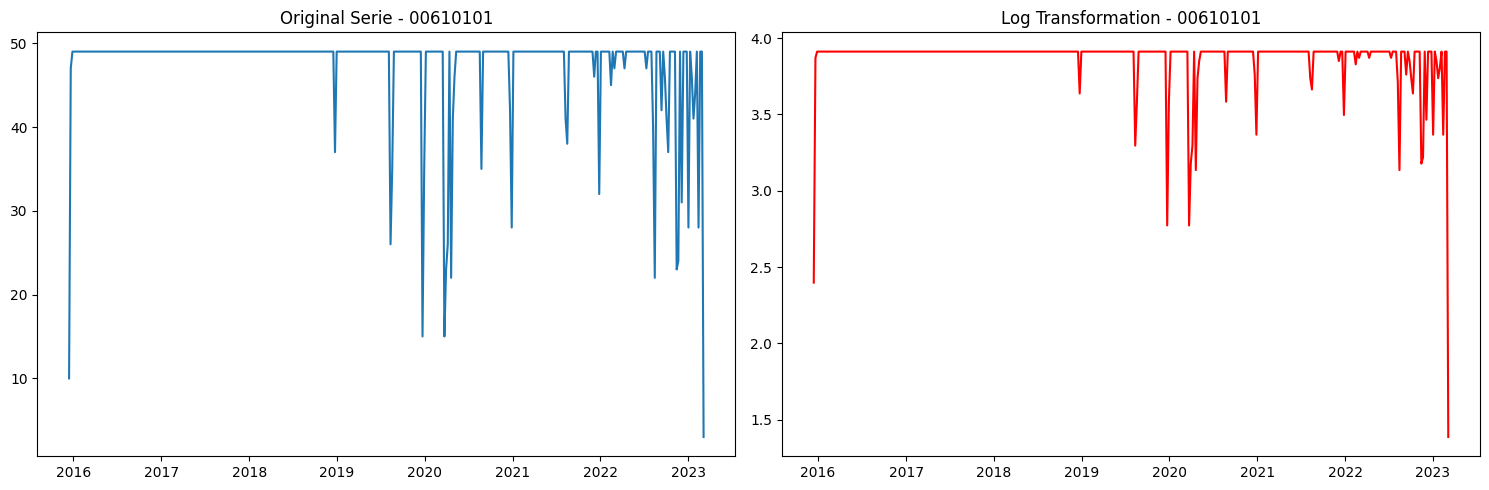

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'timeIndex' is not defined
    log ~ timeIndex
          ^^^^^^^^^

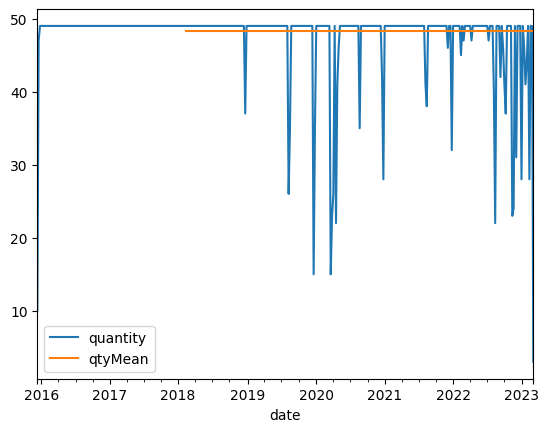

In [87]:
for item in id_list:
    one_product = sales[sales['id']==item]
    one_product = one_product.drop_duplicates()
    ts_plot = initial_plots(one_product, item)
    split_date, train, test = split(one_product)
    one_product, test = apply_mean_model(one_product, train, test, item)
    one_product, test = apply_linear_model(one_product, train, test, item)
    
    print(one_product)
    
    

In [ ]:
id_ex = '17410306'
m = sales[sales['id']== id_ex]



In [33]:
metrics


,id,model,rmse,mape,mase,wape
0,00610101,mean,125.728299,2.982819e+00,NaN,5.200601e+06
1,00610101AC,mean,6.492486,4.718057e+14,NaN,6.987782e+04


In [78]:
one_product

,id,date,quantity,log
756,00610101AC,2020-05-04,5,1.791759
906,00610101AC,2020-05-11,1,0.693147
758,00610101AC,2020-05-18,6,1.945910
759,00610101AC,2020-05-25,9,2.302585
909,00610101AC,2020-06-01,3,1.386294
...,...,...,...,...
1049,00610101AC,2023-02-06,5,1.791759
901,00610101AC,2023-02-13,0,0.000000
902,00610101AC,2023-02-20,9,2.302585
1052,00610101AC,2023-02-27,1,0.693147
